In [30]:
import numpy as np
import pandas as pd
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

# Data

In [31]:
# variable names key
key = pd.read_csv('data/VariableLookup.csv')
print(key.shape)
key.head()

(83, 3)


,Field,LongName,Description
0,CensusTract,Census tract,Census tract number
1,State,State,State name
2,County,County,County name
3,Urban,Urban tract,Flag for urban tract
4,POP2010,"Population, tract total",Population count from 2010 census


In [32]:
# full dataset
df = pd.read_csv('data/USDA_ERS_data.csv')

In [33]:
# rename hispanic columns for compatibility
df = df.rename(columns = {'lahisp1':'lahispanic1', 
                          'lahisp1share':'lahispanic1share', 
                          'lahisp10':'lahispanic10', 
                          'lahisp10share':'lahispanic10share'})
df.columns

Index(['CensusTract', 'State', 'County', 'Urban', 'Pop2010', 'OHU2010',
       'GroupQuartersFlag', 'NUMGQTRS', 'PCTGQTRS', 'LILATracts_1And10',
       'HUNVFlag', 'LowIncomeTracts', 'PovertyRate', 'MedianFamilyIncome',
       'LA1and10', 'LATracts1', 'LATracts10', 'LAPOP1_10', 'LALOWI1_10',
       'lapop1', 'lapop1share', 'lalowi1', 'lalowi1share', 'lakids1',
       'lakids1share', 'laseniors1', 'laseniors1share', 'lawhite1',
       'lawhite1share', 'lablack1', 'lablack1share', 'laasian1',
       'laasian1share', 'lanhopi1', 'lanhopi1share', 'laaian1', 'laaian1share',
       'laomultir1', 'laomultir1share', 'lahispanic1', 'lahispanic1share',
       'lahunv1', 'lahunv1share', 'lasnap1', 'lasnap1share', 'lapop10',
       'lapop10share', 'lalowi10', 'lalowi10share', 'lakids10',
       'lakids10share', 'laseniors10', 'laseniors10share', 'lawhite10',
       'lawhite10share', 'lablack10', 'lablack10share', 'laasian10',
       'laasian10share', 'lanhopi10', 'lanhopi10share', 'laaian10',
    

In [34]:
# adding column for adults (age 18-64)
df['laadults1'] = df['lapop1'] - df['lakids1'] - df['laseniors1']
df['laadults10'] = df['lapop10'] - df['lakids10'] - df['laseniors10']
df['TractAdults'] = df['Pop2010'] - df['TractKids'] - df['TractSeniors']
print(df.shape)
df.head()

(72531, 86)


,CensusTract,State,County,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,...,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,laadults1,laadults10,TractAdults
0,1001020100,Alabama,Autauga County,1,1912,693,0,0.0,0.00,0,...,14.0,0.0,14.0,45.0,44.0,6.0,102.0,1173.0,NaN,1184.0
1,1001020200,Alabama,Autauga County,1,2170,743,0,181.0,8.34,1,...,5.0,0.0,5.0,55.0,75.0,89.0,156.0,728.0,NaN,1350.0
2,1001020300,Alabama,Autauga County,1,3373,1256,0,0.0,0.00,0,...,17.0,5.0,11.0,117.0,87.0,99.0,172.0,935.0,NaN,2040.0
3,1001020400,Alabama,Autauga County,1,4386,1722,0,0.0,0.00,0,...,18.0,4.0,11.0,74.0,85.0,21.0,98.0,780.0,NaN,2467.0
4,1001020500,Alabama,Autauga County,1,10766,4082,0,181.0,1.68,0,...,296.0,9.0,48.0,310.0,355.0,230.0,339.0,1566.0,NaN,6478.0


# Median Income

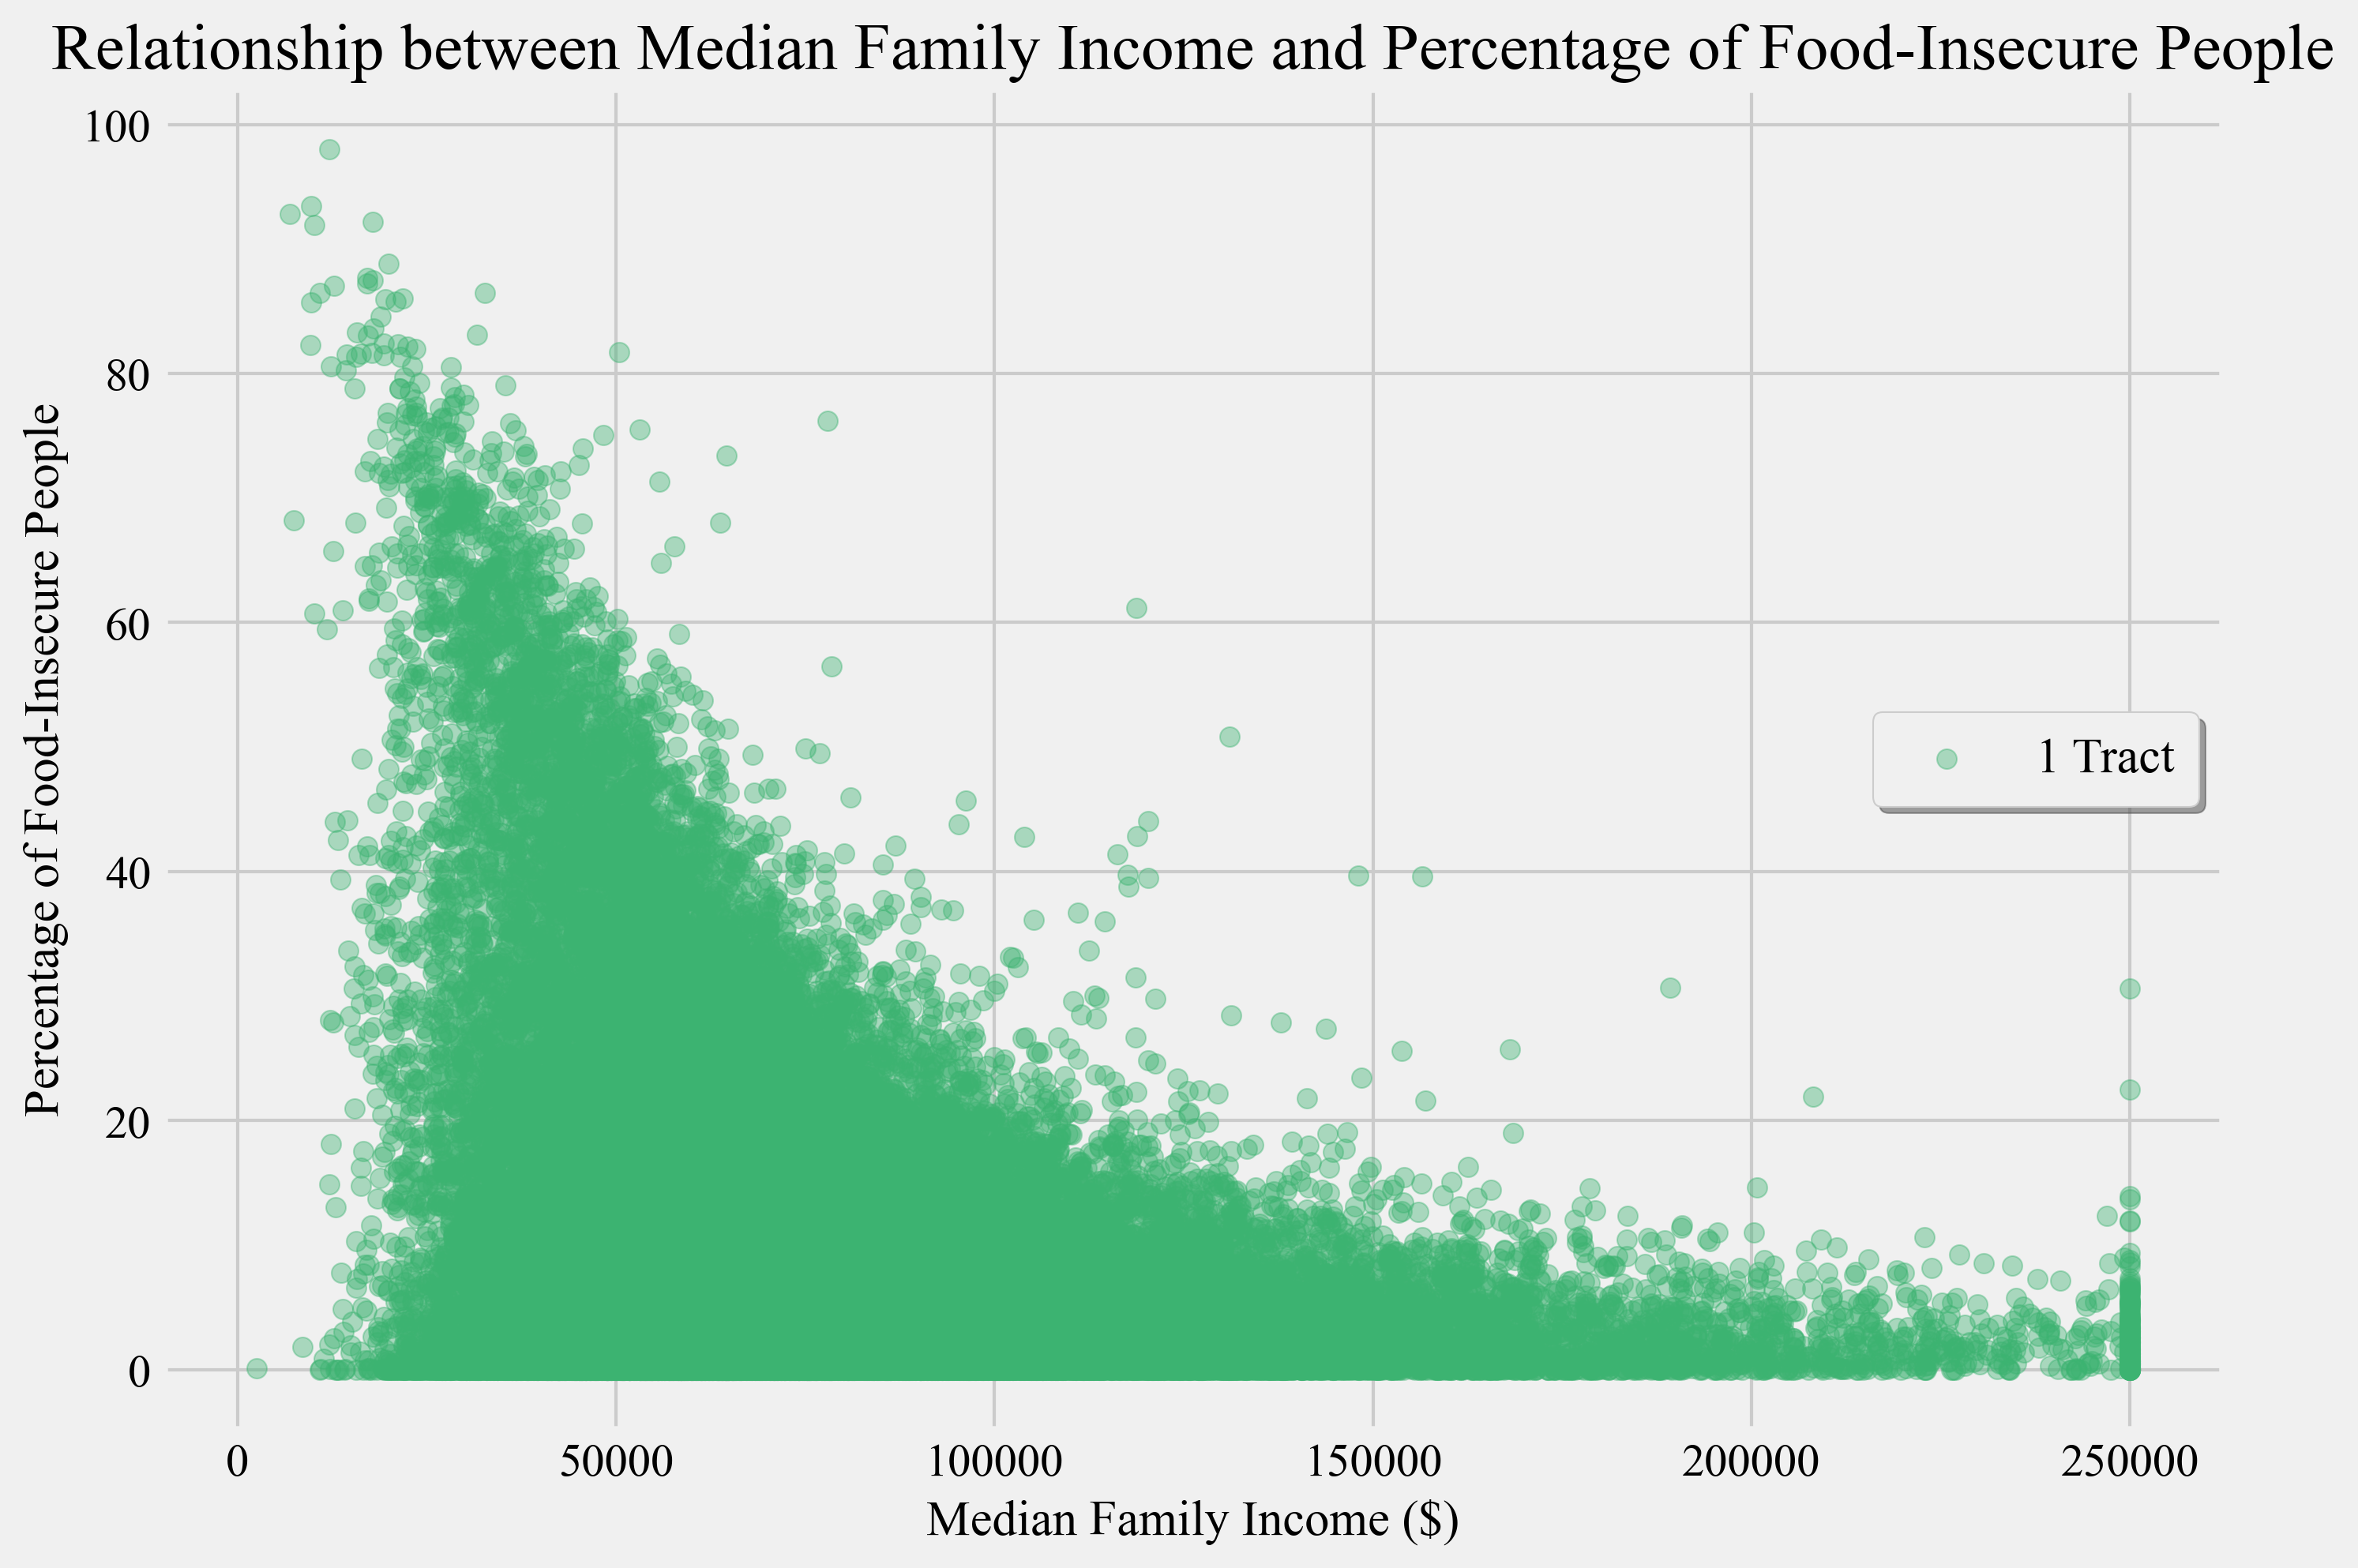

In [35]:
# relationship between median family income and percentage of food-insecure people
# each point represents a single tract

plt.figure(figsize=(10, 7))
plt.scatter(df['MedianFamilyIncome'], (df['LALOWI1_10']/df['Pop2010'])*100, alpha=0.4, label = '1 Tract', color = 'mediumseagreen')
plt.title('Relationship between Median Family Income and Percentage of Food-Insecure People', size = 20)
plt.legend(loc='center right', fontsize = 15, fancybox=True, framealpha=1, shadow=True, borderpad=0.5)
plt.xlabel('Median Family Income ($)', size = 15)
plt.ylabel('Percentage of Food-Insecure People', size = 15);
plt.savefig('figures/income_poverty/income-scatter.png', bbox_inches = 'tight', transparent = True)

# Income Brackets

In [36]:
# group tracts by median income, range = 10k
bins = np.arange(0, 10000+max(df['MedianFamilyIncome']), 10000)
income_df = df.groupby(pd.cut(df['MedianFamilyIncome'], bins)).sum()

# adds column with total number of tracts in each income bracket
income_df['NumTracts'] = df.groupby(pd.cut(df['MedianFamilyIncome'], bins)).count()['Urban']
print(income_df.shape)
income_df.head()

(26, 85)


,CensusTract,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,HUNVFlag,LowIncomeTracts,...,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,laadults1,laadults10,TractAdults,NumTracts
MedianFamilyIncome,,,,,,,,,,,,,,,,,,,,,
"(0.0, 10000.0]",438833066217,16,31052,10761,1,2630.0,152.27,5,9,16,...,56.0,290.0,2324.0,4807.0,5058.0,6885.0,8542.0,0.0,18257.0,16
"(10000.0, 20000.0]",10523156416027,358,963779,351619,9,87183.0,2757.38,108,219,363,...,728.0,17890.0,101042.0,171384.0,142255.0,175848.0,101665.0,3239.0,603442.0,363
"(20000.0, 30000.0]",65563672874090,2211,7675185,2715779,12,340113.0,9487.80,643,1156,2322,...,9157.0,139092.0,1170404.0,2355022.0,775525.0,1081529.0,937034.0,43356.0,4737885.0,2322
"(30000.0, 40000.0]",147897859001999,4782,20554293,7337114,14,597807.0,15554.11,1582,2313,5439,...,28397.0,424336.0,3419369.0,6725141.0,1404288.0,2230588.0,2967041.0,190722.0,12696662.0,5439
"(40000.0, 50000.0]",225612017664267,6329,34002271,12543003,24,983126.0,22568.48,2643,2854,8280,...,60251.0,540999.0,4761902.0,9015951.0,1588050.0,2761532.0,6973847.0,451067.0,21179183.0,8377


In [37]:
# proportion of food-insecure tracts in each income bracket
prop_insecure_tracts = pd.DataFrame({'Food-Insecure Tracts, %': np.round((income_df['LILATracts_1And10']/income_df['NumTracts'])*100, 2)})

incomes = []
for i in range(26):
    incomes.append(str(i) + '-' + str(i+1))
prop_insecure_tracts['Median Income (10K)'] = incomes
prop_insecure_tracts.head()

,"Food-Insecure Tracts, %",Median Income (10K)
MedianFamilyIncome,,
"(0.0, 10000.0]",31.25,0-1
"(10000.0, 20000.0]",29.75,1-2
"(20000.0, 30000.0]",27.69,2-3
"(30000.0, 40000.0]",29.09,3-4
"(40000.0, 50000.0]",31.55,4-5


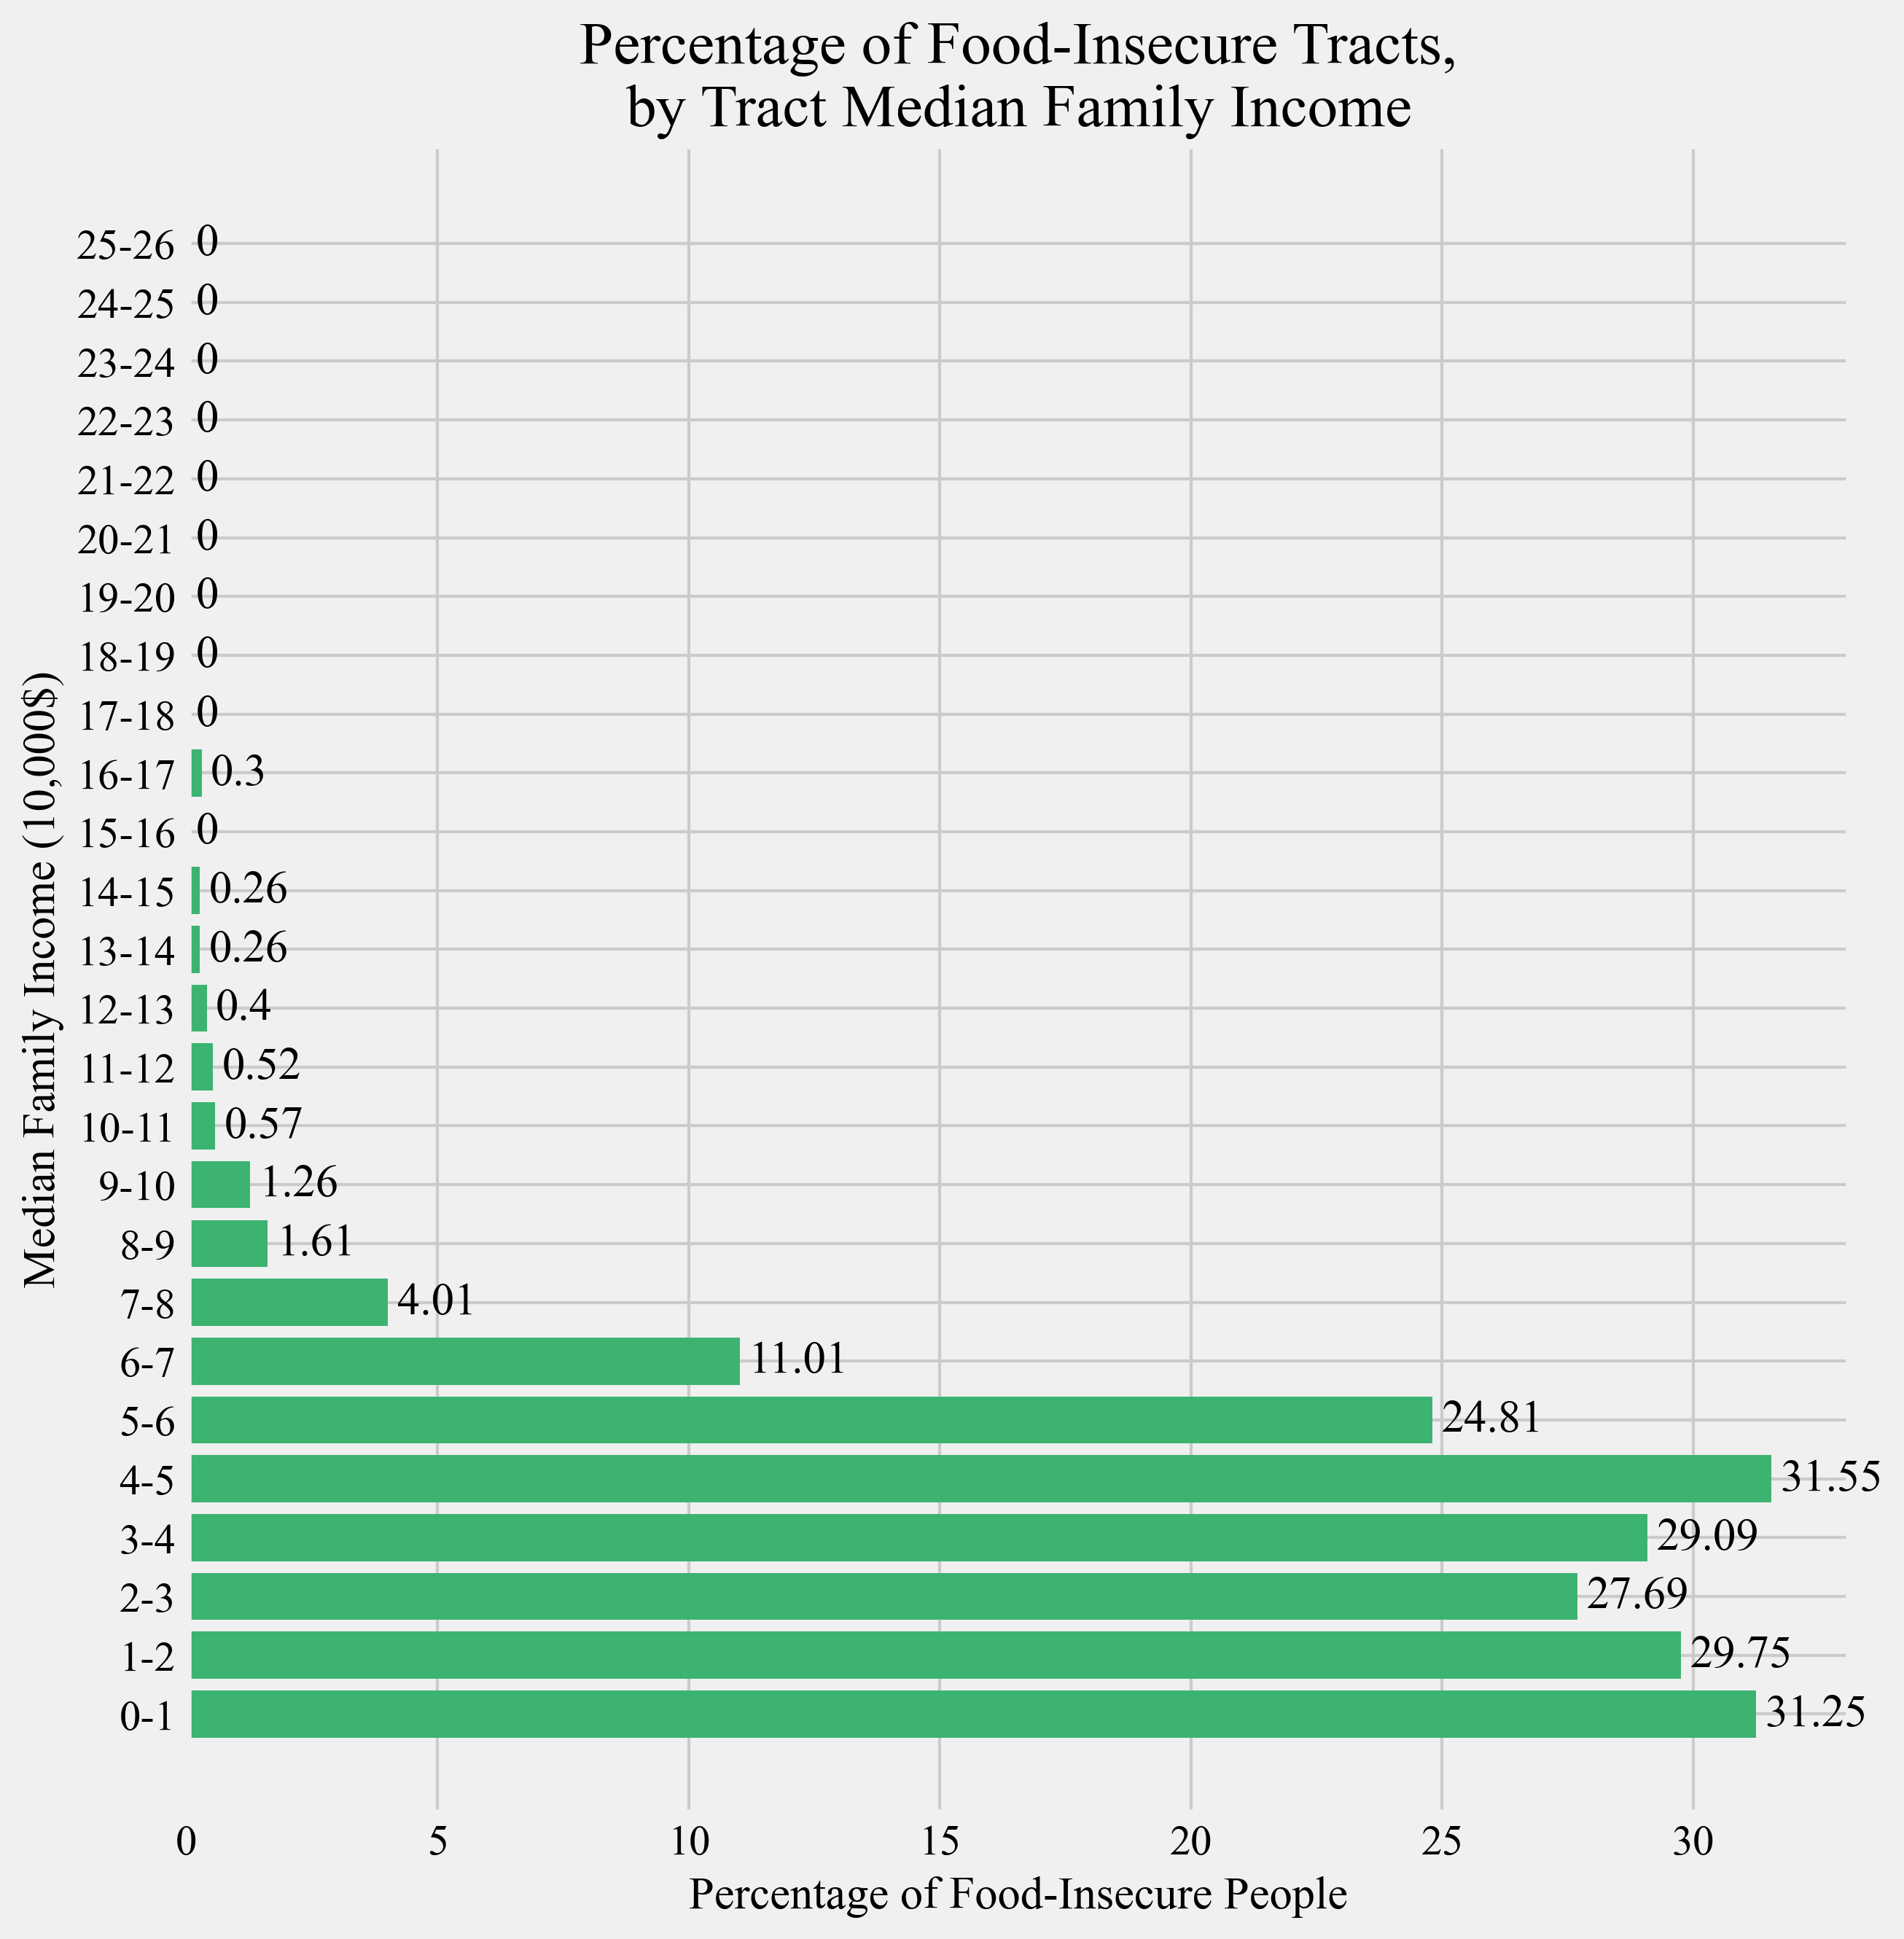

In [38]:
# what the graph is saying: "in tracts with median family income x-y, what percent of those tracts are food-insecure"

labels = prop_insecure_tracts['Median Income (10K)']
prop = prop_insecure_tracts['Food-Insecure Tracts, %']

x = np.arange(len(labels))  # label locations
width = 0.8  # width of the bars

fig, ax = plt.subplots()
rects1 = ax.barh(x, prop, width, color='mediumseagreen')

# add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Percentage of Food-Insecure People', size = 15)
ax.set_ylabel('Median Family Income (10,000$)', size = 15)
ax.set_title('Percentage of Food-Insecure Tracts,\nby Tract Median Family Income', size = 20)
ax.set_yticks(x)
ax.set_yticklabels(labels)

# bar labels
ax.bar_label(rects1, padding=3, size = 15)

fig.tight_layout()
fig.set_size_inches(10, 12)

#saves figure as png
plt.savefig('figures/income_poverty/income-tract-bar.png', bbox_inches = 'tight', transparent = True)
plt.show()

In [39]:
# proportion of food-insecure people in each income bracket for 1mi, 10mi, and both
income_insecure_df = pd.DataFrame({'1+ Miles, %': np.round((income_df['lalowi1']/income_df['Pop2010'])*100, 2),
                                   '10+ Miles, %': np.round((income_df['lalowi10']/income_df['Pop2010'])*100, 2),
                                   '1+ and 10+ Miles, %': np.round((income_df['LALOWI1_10']/income_df['Pop2010'])*100, 2)})

income_insecure_df['Median Income (10K)'] = incomes
income_insecure_df.head()

,"1+ Miles, %","10+ Miles, %","1+ and 10+ Miles, %",Median Income (10K)
MedianFamilyIncome,,,,
"(0.0, 10000.0]",32.83,0.00,32.83,0-1
"(10000.0, 20000.0]",14.37,0.51,13.90,1-2
"(20000.0, 30000.0]",14.05,0.71,11.97,2-3
"(30000.0, 40000.0]",14.16,0.96,9.77,3-4
"(40000.0, 50000.0]",16.32,1.08,8.28,4-5


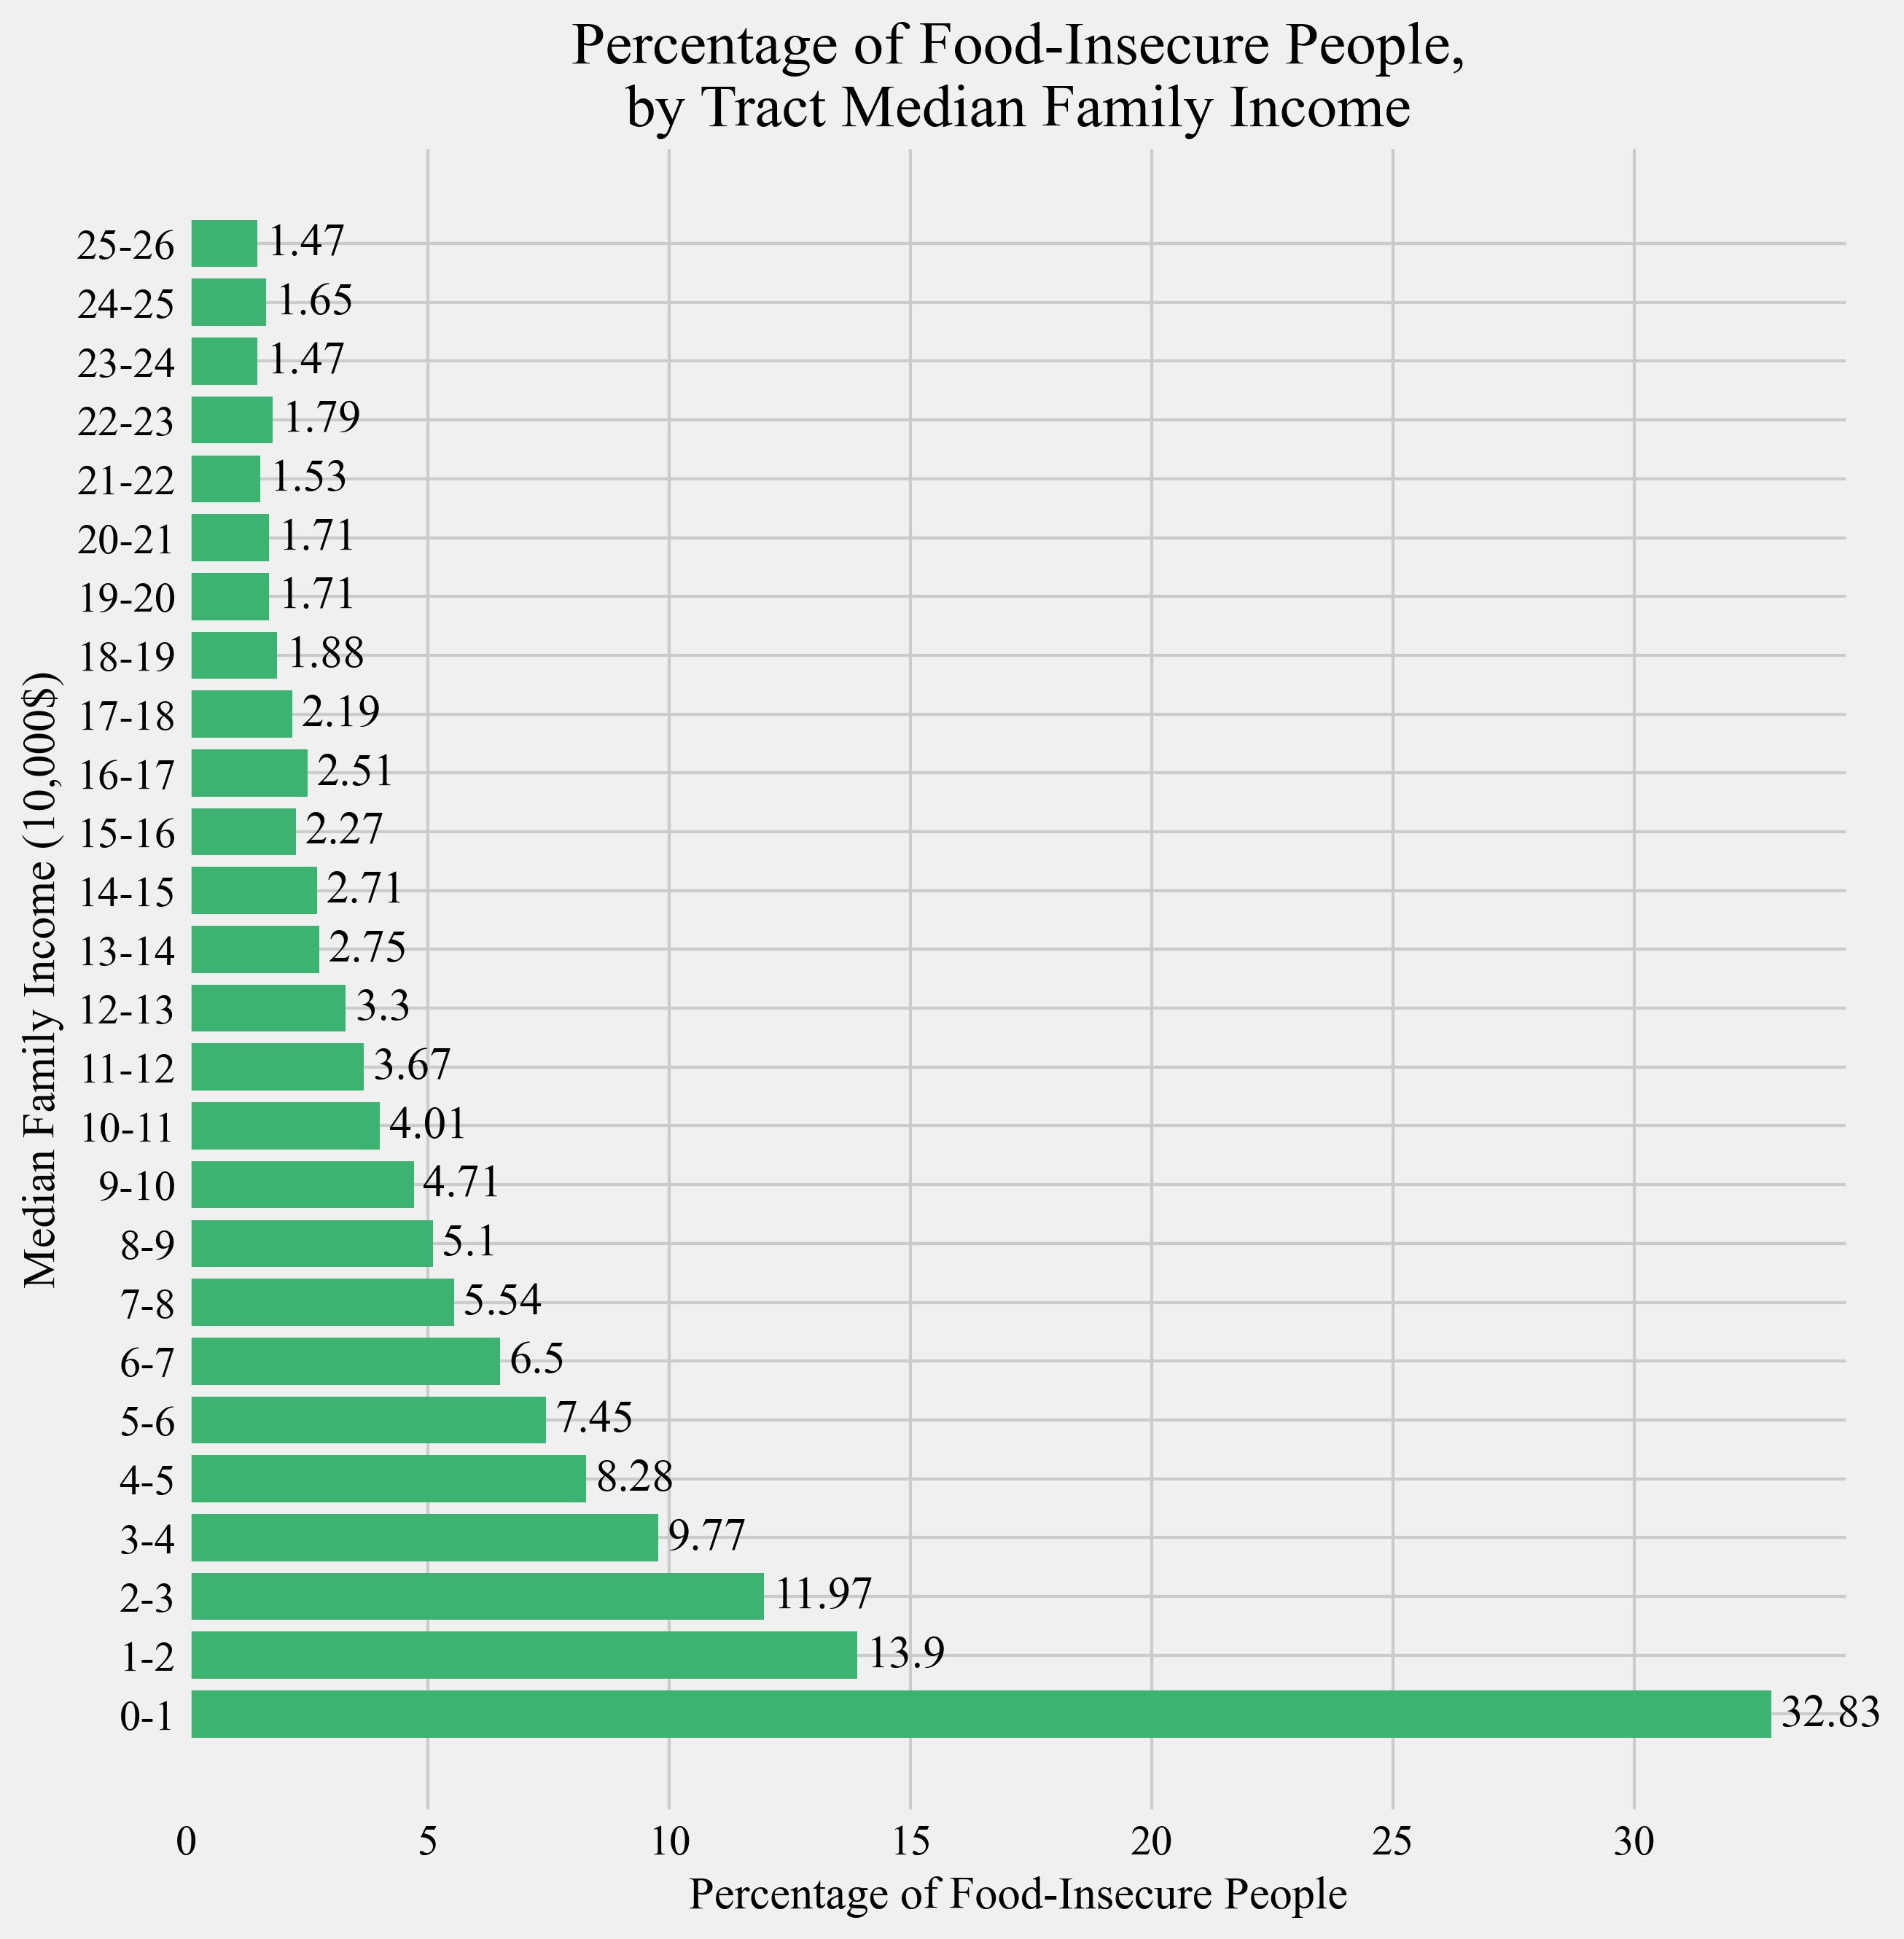

In [40]:
# what the graph is saying: "in tracts with median family income x-y, what percent of people are food-insecure"

labels = income_insecure_df['Median Income (10K)']
prop = income_insecure_df['1+ and 10+ Miles, %']

x = np.arange(len(labels))  # label locations
width = 0.8  # width of the bars

fig, ax = plt.subplots()
rects1 = ax.barh(x, prop, width, color='mediumseagreen')

# add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Percentage of Food-Insecure People', size = 15)
ax.set_ylabel('Median Family Income (10,000$)', size = 15)
ax.set_title('Percentage of Food-Insecure People,\nby Tract Median Family Income', size = 20)
ax.set_yticks(x)
ax.set_yticklabels(labels)

# bar labels
ax.bar_label(rects1, padding=3, size = 15)

fig.tight_layout()
fig.set_size_inches(10, 12)

#saves figure as png
plt.savefig('figures/income_poverty/income-people-bar.png', bbox_inches = 'tight', transparent = True)
plt.show()

# Poverty Rate

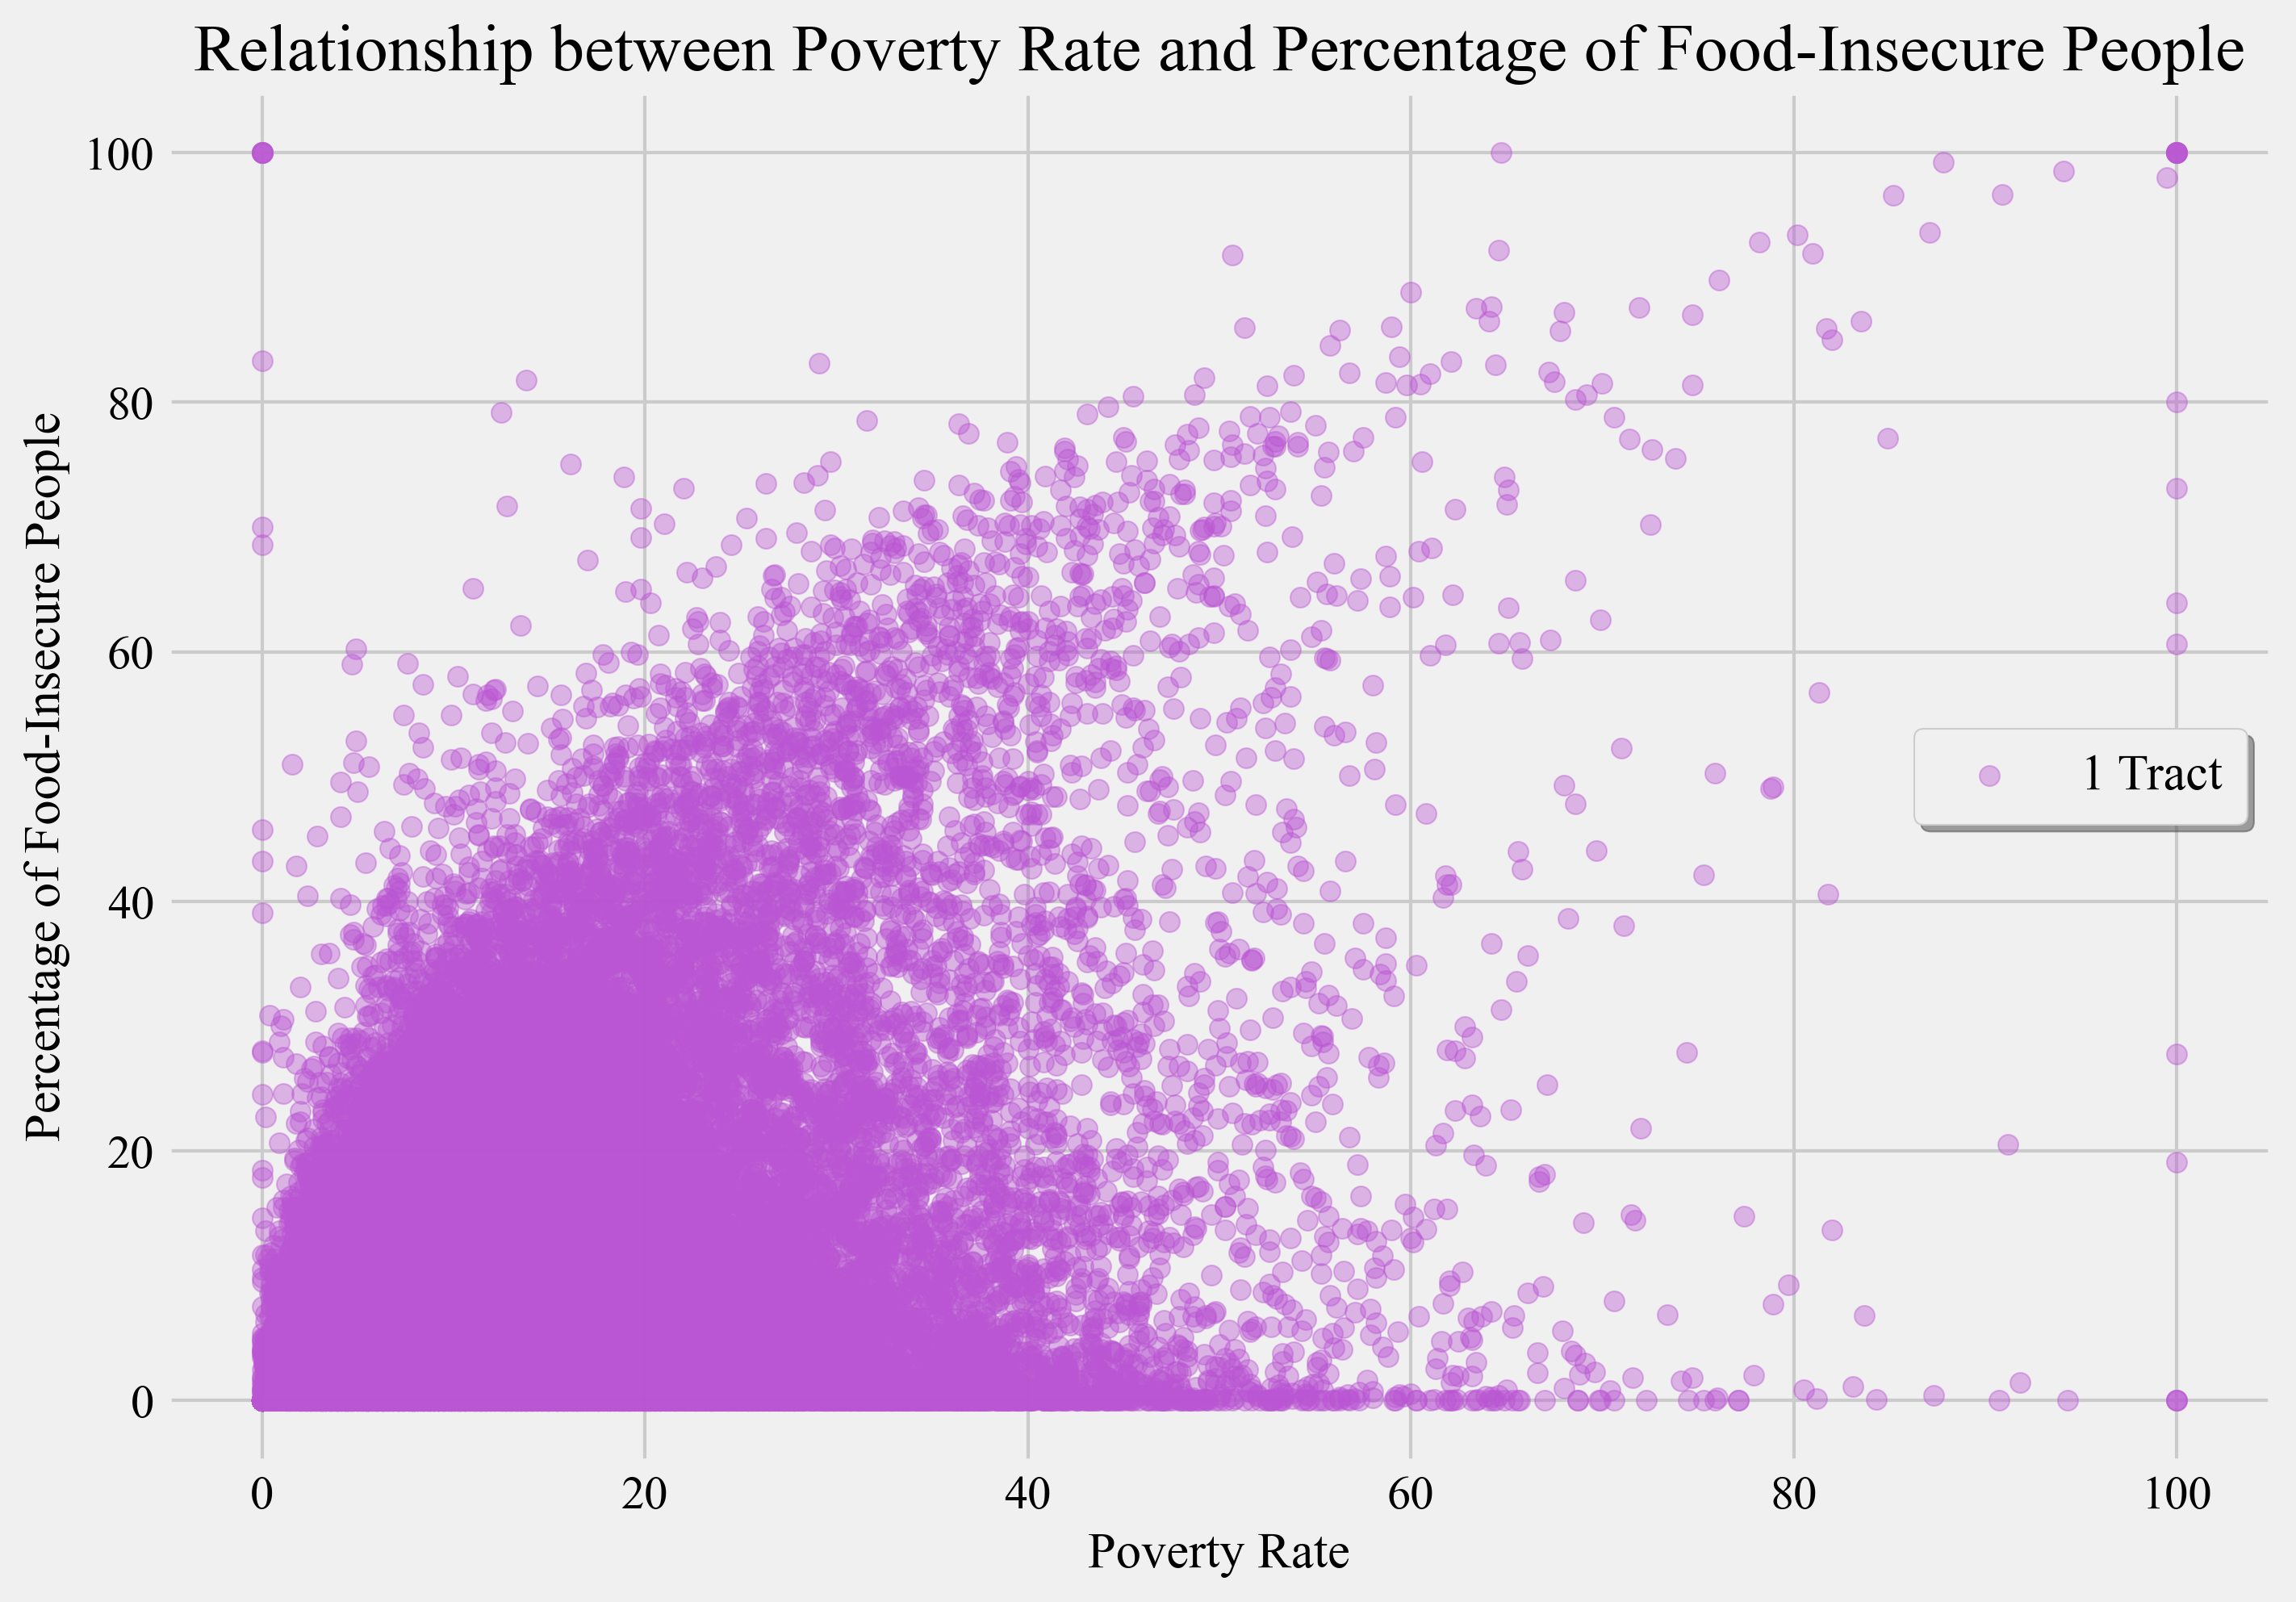

In [41]:
# relationship between poverty rate and percentage of food-insecure people
# each point represents a single tract

plt.figure(figsize=(10, 7))
plt.scatter(df['PovertyRate'], (df['LALOWI1_10']/df['Pop2010'])*100, alpha=0.4, label = '1 Tract', color = 'mediumorchid')
plt.title('Relationship between Poverty Rate and Percentage of Food-Insecure People', size = 20)
plt.legend(loc='center right', fontsize = 15, fancybox=True, framealpha=1, shadow=True, borderpad=0.5)
plt.xlabel('Poverty Rate', size = 15)
plt.ylabel('Percentage of Food-Insecure People', size = 15);
plt.savefig('figures/income_poverty/poverty-tract-scatter.png', bbox_inches = 'tight', transparent = True)

In [42]:
# group by states
state_df = df.groupby(by='State').sum().reset_index()
state_df['prop_insecure'] = (state_df['LALOWI1_10']/state_df['Pop2010']) * 100
print(state_df.shape)
state_df.head()

(51, 86)


,State,CensusTract,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,HUNVFlag,...,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,laadults1,laadults10,TractAdults,prop_insecure
0,Alabama,1267818290482,644,4779736,1883791,4,115816.0,2973.89,267,347,...,3057.0,28218.0,168161.0,185602.0,115360.0,269603.0,1829544.0,75239.0,2989485.0,8.760756
1,Alaska,351430086585,84,710231,258058,1,26343.0,739.26,33,51,...,7409.0,97786.0,62823.0,39242.0,22474.0,25855.0,252767.0,42001.0,463961.0,7.868708
2,Arizona,6102878346451,1292,6392017,2380990,16,137469.0,3065.05,257,284,...,12648.0,296529.0,980016.0,1895149.0,160011.0,298356.0,1342250.0,145030.0,3881172.0,8.680077
3,Arkansas,3484080853747,335,2915918,1147084,1,78931.0,1880.62,171,232,...,5863.0,22248.0,156581.0,186050.0,73619.0,146798.0,1083580.0,103658.0,1784462.0,10.015748
4,California,48584591545832,7353,37253956,12577498,67,819805.0,18522.21,536,755,...,144386.0,362801.0,8132756.0,14013719.0,939034.0,1184714.0,4299125.0,128381.0,23712402.0,3.234459


In [43]:
#merge state poverty rates dataset with state_df
state_poverty = pd.read_csv('data/Poverty2017-18.csv')
state_df = state_df.merge(state_poverty)

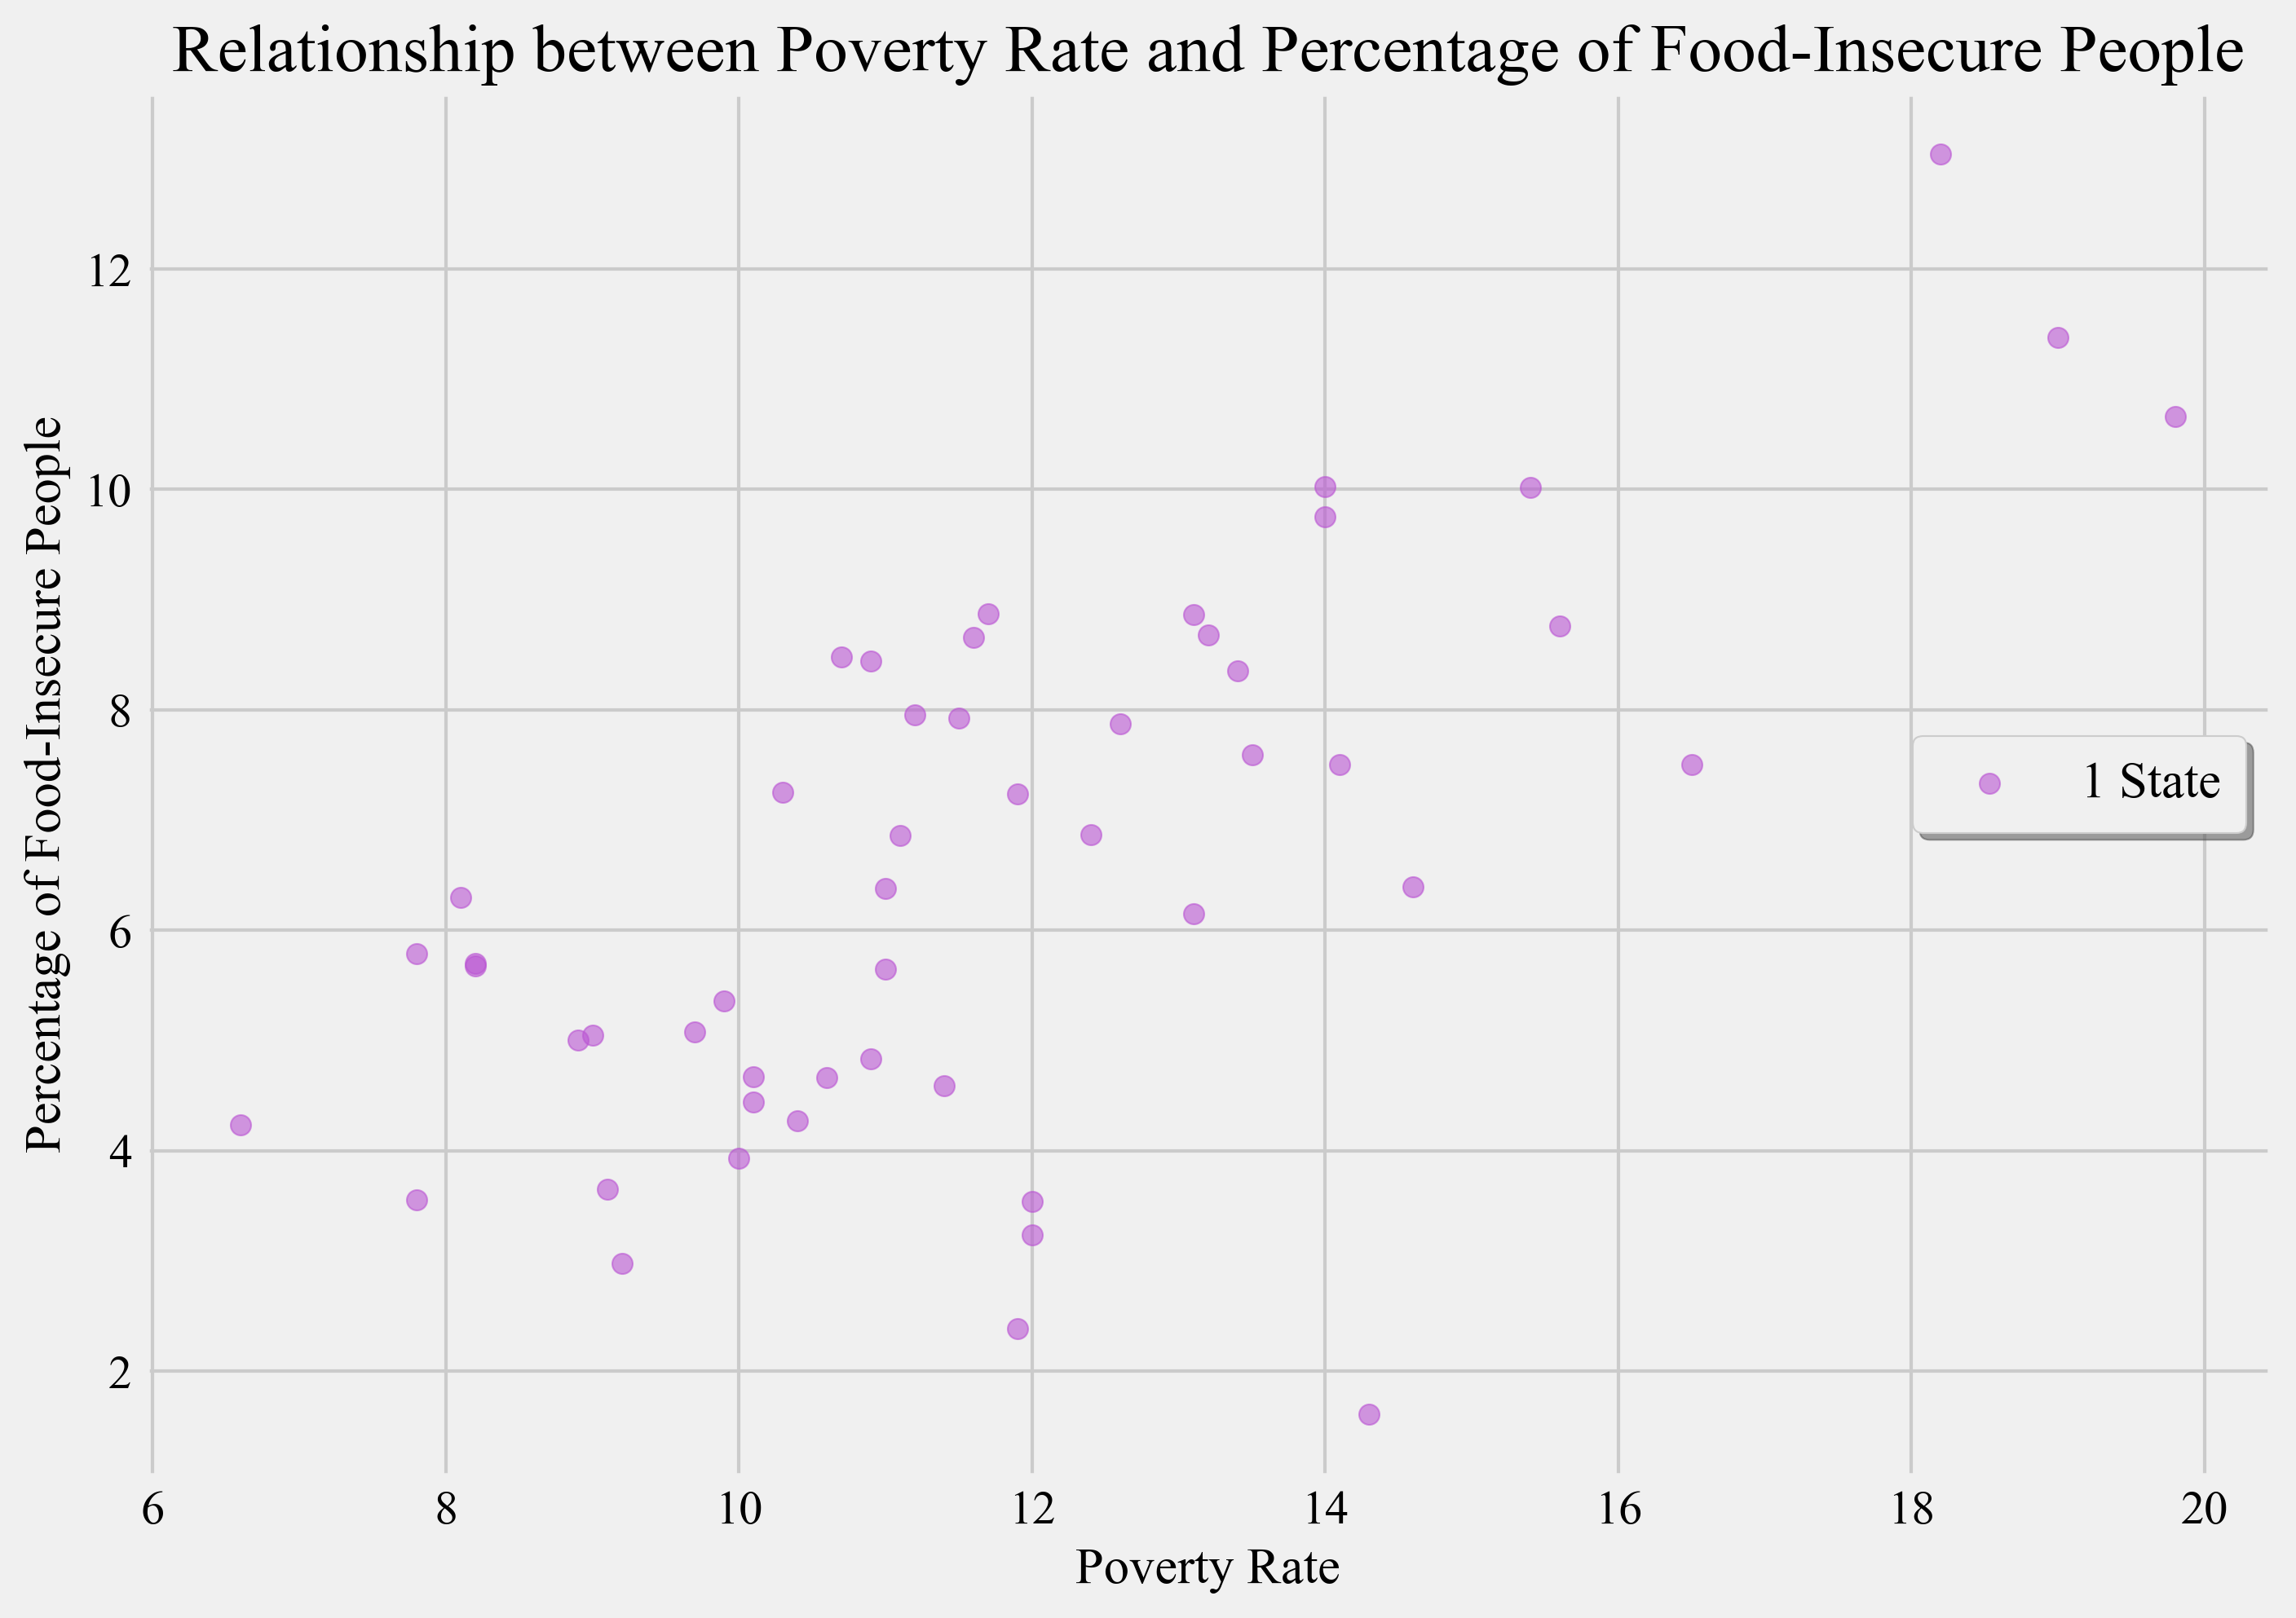

In [44]:
# relationship between poverty rate and percentage of food-insecure people
# each point represents a single state

plt.figure(figsize=(10, 7))
plt.scatter(state_df['Poverty Rate'], (state_df['LALOWI1_10']/state_df['Pop2010'])*100, alpha=0.6, label = '1 State', color = 'mediumorchid')
plt.title('Relationship between Poverty Rate and Percentage of Food-Insecure People', size = 20)
plt.legend(loc='center right', fontsize = 15, fancybox=True, framealpha=1, shadow=True, borderpad=0.5)
plt.xlabel('Poverty Rate', size = 15)
plt.ylabel('Percentage of Food-Insecure People', size = 15);
plt.savefig('figures/income_poverty/poverty-state-scatter.png', bbox_inches = 'tight', transparent = True)